In [340]:
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2

env: OMP_NUM_THREADS=10
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/nicholas/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'imread', 'imsave', 'random', 'meshgrid', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [341]:
from __future__ import print_function
import os
import sys
import cv2
import math
import pickle
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from collections import namedtuple
import importlib
import inspect
from collections import namedtuple
import time
import glob
from imageio import imread, imsave
#print('USE GPU #{} Host={}'.format(os.environ.get('CUDA_VISIBLE_DEVICES'), os.uname()[1]))
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [342]:
LOCAL_PATH = '../'
if LOCAL_PATH not in sys.path:
    sys.path.append(LOCAL_PATH)
from common.tf_layer_utils import *
from mydatasets import *
from det_tools import *
from inference import *
MODEL_PATH = '../models/'
if MODEL_PATH not in sys.path:
    sys.path.append(MODEL_PATH)
COMMON_PATH = '../common/'
if COMMON_PATH not in sys.path:
    sys.path.append(COMMON_PATH)
    
from io_utils import read_text
from jupyter_utils import display_image_batch


In [343]:
given_config = namedtuple('params', 'model')
given_config.model = '/data/lfnet/release/models/outdoor/'
#default: given_config.top_k=1024
given_config.top_k = 1024
yfcc_dir = '/data/lfnet/release/outdoor_examples/'
given_config.img_dir = os.path.join(yfcc_dir, 'images')
given_config.dpt_dir = os.path.join(yfcc_dir, 'depths')
given_config.seq_names = ['sacre_coeur']
given_config.dist_thresh = 5

In [344]:
# load config file
config_path = os.path.join(given_config.model, 'config.pkl')
try:
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
except:
    raise ValueError('Fail to open {}'.format(config_path))

# overwrite each given_config parameters
for attr, dst_val in sorted(vars(given_config).items()):
    if attr.startswith('_'):
        continue
    elif hasattr(config, attr):
        src_val = getattr(config, attr)
        if src_val != dst_val:
            print('Overwrite {} : {} --> {}'.format(attr, src_val, dst_val))
            setattr(config, attr, dst_val)
    else:
        print('Add {} {}'.format(attr, dst_val))
        setattr(config, attr, dst_val)

Add dist_thresh 5
Add dpt_dir /data/lfnet/release/outdoor_examples/depths
Add img_dir /data/lfnet/release/outdoor_examples/images
Add model /data/lfnet/release/models/outdoor/
Add seq_names ['sacre_coeur']
Overwrite top_k : 512 --> 1024


In [345]:
tf.reset_default_graph()
"""
batch_size = 1 # fixed
data_loader = RawSfMDataset(longer_edge=640)

dataset = data_loader.get_dataset(config.dpt_dir, config.img_dir, 
                config.seq_names, phase='valid', shuffle=True, seed=12345, max_examples=500)

next_batch = dataset.make_one_shot_iterator().get_next()
photos1, photos2, depths1, depths2, valid_masks1, valid_masks2, c2Tc1s, c1Tc2s, c1Tws, c2Tws, Ks1, Ks2, theta_params, use_aug = next_batch
rgbs1 = tf.concat([photos1, photos1, photos1], axis=-1)
rgbs2 = tf.concat([photos2, photos2, photos2], axis=-1)
# Not apply any augmentations
thetas1 = tf.tile(tf.eye(3)[None], [batch_size, 1, 1])
thetas2 = tf.tile(tf.eye(3)[None], [batch_size, 1, 1])
inv_thetas1 = tf.matrix_inverse(thetas1)
inv_thetas2 = tf.matrix_inverse(thetas2)
# next_batch = [photos1, photos2, depths1, depths2, valid_masks1, valid_masks2, 
#               c2Tc1s, c1Tc2s, c1Tws, c2Tws, Ks1, Ks2, 
#               thetas1, thetas2, inv_thetas1, inv_thetas2, theta_params]

# photos1 = tf.placeholder(tf.float32, [None,None,None,1])
# photos2 = tf.placeholder(tf.float32, [None,None,None,1])
"""

photos1 = tf.placeholder(tf.float32, [None,None,None,1])
photos2 = tf.placeholder(tf.float32, [None,None,None,1])
is_training = tf.placeholder(tf.bool)

DATASET_DIR = "/data/YCJ_bkp/fyp_ycj/six_dof_1cm5deg_A2/img"
dataset = CDataset()
#TODO: longer edge? Current image size is 480x640x3
dataset.load_img_from_dir(DATASET_DIR)
dataset.prepare(shuffle=True)

In [346]:
rgb1, grey1, rgb2, grey2 = dataset.get_next()

### Detect and describe local features

In [347]:
DET = importlib.import_module(config.detector)
detector = DET.Model(config, is_training)

if config.use_nms3d:
    print('Apply 3D NMS instead.')
    heatmaps1, det_endpoints = build_multi_scale_deep_detector_3DNMS(config, detector, photos1, reuse=False)
    heatmaps2, det_endpoints2 = build_multi_scale_deep_detector_3DNMS(config, detector, photos2, reuse=True)
else:
    heatmaps1, det_endpoints = build_multi_scale_deep_detector(config, detector, photos1, reuse=False)
    heatmaps2, det_endpoints2 = build_multi_scale_deep_detector(config, detector, photos2, reuse=True)

degree_maps1 = visualize_degree_map(det_endpoints['ori_maps'])
degree_maps2 = visualize_degree_map(det_endpoints2['ori_maps'])

Act-Fn:  <function get_activation_fn.<locals>.<lambda> at 0x7fa704589d08>
Apply 3D NMS instead.
Scales (0.707107~1.41 #5): [1.41421356 1.18920712 1.         0.84089642 0.70710678]
INFO:tensorflow:Summary name ConvOnlyResNet/ori_conv/weights:0 is illegal; using ConvOnlyResNet/ori_conv/weights_0 instead.
INFO:tensorflow:Summary name ConvOnlyResNet/ori_conv/biases:0 is illegal; using ConvOnlyResNet/ori_conv/biases_0 instead.
PAD=16, #conv=8, ksize=5 ori-ksize=5
Scales (0.707107~1.41 #5): [1.41421356 1.18920712 1.         0.84089642 0.70710678]
PAD=16, #conv=8, ksize=5 ori-ksize=5


In [348]:
# extract patches
kpts1 = det_endpoints['kpts']
kpts2 = det_endpoints2['kpts']
batch_inds1 = det_endpoints['batch_inds']

kp_patches1 = build_patch_extraction(config, det_endpoints, photos1)
kp_patches2 = build_patch_extraction(config, det_endpoints2, photos2)

# Descriptor
DESC = importlib.import_module(config.descriptor)
descriptor = DESC.Model(config, is_training)
desc_feats1, desc_endpoints = descriptor.build_model(kp_patches1, reuse=False) # [B*K,D]
desc_feats2, _          = descriptor.build_model(kp_patches2, reuse=True) # [B*K,D]

Act-Fn:  <function relu at 0x7fa7b5298510>
===== SimpleDesc (reuse=False) =====
#1 conv-bn-act (?, 16, 16, 64)
#2 conv-bn-act (?, 8, 8, 128)
#3 conv-bn-act (?, 4, 4, 256)
FLAT (?, 4096)
Feat-Norm: L2-NORM
FEAT (?, 256)
===== SimpleDesc (reuse=True) =====
#1 conv-bn-act (?, 16, 16, 64)
#2 conv-bn-act (?, 8, 8, 128)
#3 conv-bn-act (?, 4, 4, 256)
FLAT (?, 4096)
Feat-Norm: L2-NORM
FEAT (?, 256)


In [349]:
nn_dist, nn_inds2, _, _, _ = nearest_neighbors(desc_feats1, desc_feats2)
kpts2_corr = tf.cast(tf.gather(kpts2, nn_inds2), tf.float32)

### Check with Ground truth

In [350]:
"""
kpts1_int = tf.cast(kpts1, tf.int32)
heatmaps1w, visible_masks1, xy_maps1to2 = \
    inverse_warp_view_2_to_1(heatmaps2, depths2, depths1, c2Tc1s, 
                            K1=Ks1, K2=Ks2, 
                            inv_thetas1=inv_thetas1, thetas2=thetas2,
                            depth_thresh=config.depth_thresh)
heatmaps2w, visible_masks2, xy_maps2to1 = \
    inverse_warp_view_2_to_1(heatmaps1, depths1, depths2, c1Tc2s, 
                            K1=Ks2, K2=Ks1,
                            inv_thetas1=inv_thetas2, thetas2=thetas1,
                            depth_thresh=config.depth_thresh)
visible_masks1 = visible_masks1 * valid_masks1 # take 'and'
visible_masks2 = visible_masks2 * valid_masks2

kpts2w = batch_gather_keypoints(xy_maps1to2, batch_inds1, kpts1_int)
kpvis2w = batch_gather_keypoints(visible_masks1, batch_inds1, kpts1_int)[:,0] 

match_dist = tf.maximum(tf.cast(tf.reduce_sum(tf.squared_difference(kpts2_corr, kpts2w), axis=1), tf.float32), 1e-6)
match_dist = tf.sqrt(match_dist)
is_match = tf.cast(tf.less_equal(match_dist, config.dist_thresh), tf.float32) * kpvis2w


# SIFT
sift_endpoints = build_competitor_matching_estimation(config, dist_thresh=config.dist_thresh)
"""

"\nkpts1_int = tf.cast(kpts1, tf.int32)\nheatmaps1w, visible_masks1, xy_maps1to2 =     inverse_warp_view_2_to_1(heatmaps2, depths2, depths1, c2Tc1s, \n                            K1=Ks1, K2=Ks2, \n                            inv_thetas1=inv_thetas1, thetas2=thetas2,\n                            depth_thresh=config.depth_thresh)\nheatmaps2w, visible_masks2, xy_maps2to1 =     inverse_warp_view_2_to_1(heatmaps1, depths1, depths2, c1Tc2s, \n                            K1=Ks2, K2=Ks1,\n                            inv_thetas1=inv_thetas2, thetas2=thetas1,\n                            depth_thresh=config.depth_thresh)\nvisible_masks1 = visible_masks1 * valid_masks1 # take 'and'\nvisible_masks2 = visible_masks2 * valid_masks2\n\nkpts2w = batch_gather_keypoints(xy_maps1to2, batch_inds1, kpts1_int)\nkpvis2w = batch_gather_keypoints(visible_masks1, batch_inds1, kpts1_int)[:,0] \n\nmatch_dist = tf.maximum(tf.cast(tf.reduce_sum(tf.squared_difference(kpts2_corr, kpts2w), axis=1), tf.float32), 1e-6)\

In [351]:
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth = True 
sess = tf.Session(config=tfconfig)
sess.run(tf.global_variables_initializer())

# load model
saver = tf.train.Saver()
print('Load trained models...')

if os.path.isdir(config.model):
    checkpoint = tf.train.latest_checkpoint(config.model)
    model_dir = config.model
else:
    checkpoint = config.model
    model_dir = os.path.dirname(config.model)

if checkpoint is not None:
    print('Checkpoint', os.path.basename(checkpoint))
    print("[{}] Resuming...".format(time.asctime()))
    saver.restore(sess, checkpoint)
else:
    raise ValueError('Cannot load model from {}'.format(model_dir))    
print('Done.')

Load trained models...
Checkpoint models-latest-42000
[Wed Apr  8 08:23:26 2020] Resuming...
INFO:tensorflow:Restoring parameters from /data/lfnet/release/models/outdoor/models-latest-42000
Done.


In [352]:
feed_dict = {
    photos1: grey1,
    photos2: grey2,
    is_training: False,
}
"""
fetch_dict = {
    'photos1': photos1,
    'photos2': photos2,
    'rgbs1': rgbs1,
    'rgbs2': rgbs2,
    'kpts1': kpts1,
    'kpts2': kpts2,
    'kpts2_corr': kpts2_corr,
    'is_match': is_match,
    'degree_maps1': degree_maps1,
    'degree_maps2': degree_maps2,
    'xy_maps1to2': xy_maps1to2,
    'visible_masks1': visible_masks1,
}
"""
fetch_dict = {
    'kpts1': kpts1,
    'kpts2': kpts2,
    'nn_dist': nn_dist,
    'kpts2_corr': kpts2_corr,
    'degree_maps1': degree_maps1,
    'degree_maps2': degree_maps2
}
outs = sess.run(fetch_dict, feed_dict=feed_dict)

In [353]:
#outs['photos1'].shape
print(rgb1.shape, grey1.shape)
print(rgb2.shape, grey2.shape)

(480, 640, 3) (1, 480, 640, 1)
(480, 640, 3) (1, 480, 640, 1)


In [354]:
# Change below to true to sort correspondences from least difference between the two descriptors
sort_top_corr = False

# Currently the easiest way to sort based on keypoint score value is to change
# given_config.top_k parameter above

#Matches = 1024


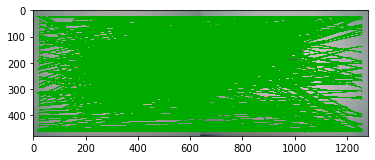

In [355]:
#rgb1 = outs['rgbs1'][0]
#rgb2 = outs['rgbs2'][0]
if sort_top_corr:
    sort_corr = np.argsort(outs['nn_dist'])
    sort_kpts1 = outs['kpts1'][sort_corr]
    sort_kpts2_corr = outs['kpts2_corr'][sort_corr]
    match_pairs = np.concatenate([sort_kpts1, sort_kpts2_corr], axis=1)[:10]
else:
    match_pairs = np.concatenate([outs['kpts1'], outs['kpts2_corr']], axis=1)

#match_pairs = match_pairs[outs['is_match']==1]

h1, w1 = rgb1.shape[:2]
h2, w2 = rgb2.shape[:2]
canvas = np.zeros((max(h1, h2), w1+w2, 3), dtype=rgb1.dtype)
canvas[:h1, :w1] = rgb1
canvas[:h2, w1:] = rgb2
fig = plt.figure(frameon=False)
fig = plt.imshow(canvas)

xs = match_pairs[:,[0,2]]
xs[:,1] += w1
ys = match_pairs[:,[1,3]]

lw = .25
alpha = 1
sf = 5
lw = .2
markersize = 1

plt.plot(
    xs.T, ys.T,
    alpha=alpha,
    linestyle="-",
    linewidth=lw,
    aa=False,
    marker='.',
    markersize=markersize,
    color=[0.0, 0.67, 0.0],
);
print('#Matches = {}'.format(len(match_pairs)))
#plt.savefig('B.jpg')

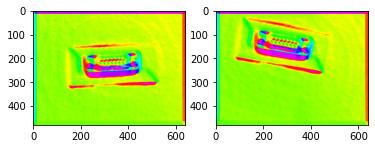

In [356]:
plt.subplot(121)
plt.imshow(outs['degree_maps1'][0])
plt.subplot(122)
plt.imshow(outs['degree_maps2'][0])

## SIFT

In [357]:
"""
sift = cv2.xfeatures2d.SIFT_create(nfeatures=config.top_k, contrastThreshold=1e-5)
sift_in1 = (rgb1[...,0]*255).astype(np.uint8)
sift_in2 = (rgb2[...,0]*255).astype(np.uint8)
kp1, des1 = sift.detectAndCompute(sift_in1,None)
kp2, des2 = sift.detectAndCompute(sift_in2,None)
kp1 = np.array([[kp.pt[0],kp.pt[1]] for kp in kp1])
kp2 = np.array([[kp.pt[0],kp.pt[1]] for kp in kp2])
print('#SIFT keypoints = {}, {}'.format(len(kp1), len(kp2)))
"""

"\nsift = cv2.xfeatures2d.SIFT_create(nfeatures=config.top_k, contrastThreshold=1e-5)\nsift_in1 = (rgb1[...,0]*255).astype(np.uint8)\nsift_in2 = (rgb2[...,0]*255).astype(np.uint8)\nkp1, des1 = sift.detectAndCompute(sift_in1,None)\nkp2, des2 = sift.detectAndCompute(sift_in2,None)\nkp1 = np.array([[kp.pt[0],kp.pt[1]] for kp in kp1])\nkp2 = np.array([[kp.pt[0],kp.pt[1]] for kp in kp2])\nprint('#SIFT keypoints = {}, {}'.format(len(kp1), len(kp2)))\n"

In [358]:
"""feed_dict = {
    sift_endpoints['feats1_ph']: des1,
    sift_endpoints['feats2_ph']: des2,
    sift_endpoints['kpts1_ph']: kp1,
    sift_endpoints['kpts2_ph']: kp2,
    sift_endpoints['xy_maps1to2_ph']: outs['xy_maps1to2'],
    sift_endpoints['visible_masks1_ph']: outs['visible_masks1']
}
fetch_dict = {
    'kpts2_corr': sift_endpoints['kpts2_corr'],
    'is_match': sift_endpoints['is_match'],
}
outs = sess.run(fetch_dict, feed_dict)
"""

"feed_dict = {\n    sift_endpoints['feats1_ph']: des1,\n    sift_endpoints['feats2_ph']: des2,\n    sift_endpoints['kpts1_ph']: kp1,\n    sift_endpoints['kpts2_ph']: kp2,\n    sift_endpoints['xy_maps1to2_ph']: outs['xy_maps1to2'],\n    sift_endpoints['visible_masks1_ph']: outs['visible_masks1']\n}\nfetch_dict = {\n    'kpts2_corr': sift_endpoints['kpts2_corr'],\n    'is_match': sift_endpoints['is_match'],\n}\nouts = sess.run(fetch_dict, feed_dict)\n"

In [359]:
"""match_pairs = np.concatenate([kp1, outs['kpts2_corr']], axis=1)
match_pairs = match_pairs[outs['is_match']==1]

h1, w1 = rgb1.shape[:2]
h2, w2 = rgb2.shape[:2]
canvas = np.zeros((max(h1, h2), w1+w2, 3), dtype=rgb1.dtype)
canvas[:h1, :w1] = rgb1
canvas[:h2, w1:] = rgb2
fig = plt.figure(frameon=False)
fig = plt.imshow(canvas)

xs = match_pairs[:,[0,2]]
xs[:,1] += w1
ys = match_pairs[:,[1,3]]

lw = .25
alpha = 1
sf = 5
lw = .2
markersize = 1

plt.plot(
    xs.T, ys.T,
    alpha=alpha,
    linestyle="-",
    linewidth=lw,
    aa=False,
    marker='.',
    markersize=markersize,
    color=[0.0, 0.67, 0.0],
);
print('#Matches = {}'.format(len(match_pairs)))
"""

'match_pairs = np.concatenate([kp1, outs[\'kpts2_corr\']], axis=1)\nmatch_pairs = match_pairs[outs[\'is_match\']==1]\n\nh1, w1 = rgb1.shape[:2]\nh2, w2 = rgb2.shape[:2]\ncanvas = np.zeros((max(h1, h2), w1+w2, 3), dtype=rgb1.dtype)\ncanvas[:h1, :w1] = rgb1\ncanvas[:h2, w1:] = rgb2\nfig = plt.figure(frameon=False)\nfig = plt.imshow(canvas)\n\nxs = match_pairs[:,[0,2]]\nxs[:,1] += w1\nys = match_pairs[:,[1,3]]\n\nlw = .25\nalpha = 1\nsf = 5\nlw = .2\nmarkersize = 1\n\nplt.plot(\n    xs.T, ys.T,\n    alpha=alpha,\n    linestyle="-",\n    linewidth=lw,\n    aa=False,\n    marker=\'.\',\n    markersize=markersize,\n    color=[0.0, 0.67, 0.0],\n);\nprint(\'#Matches = {}\'.format(len(match_pairs)))\n'